In [2]:
import torch as th
import torch.nn as nn

In [3]:
# ResNet is a typical residual network
# The residual simply means that the input is added to the output

In [4]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # This network is for images, so use convolutional layers
        # Residual network is of the form:
        # residual <- some_network(input)
        # output <- residual + input
        # each of such block is called a residual block
        # the some network can be any network, but in this case
        # it is a simple 2 layers convolutional network
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # 16 28 28
        self.in_channels = 16
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(ResidualBlock, 16, 2, stride=1)
        # Stride two 32 14 14
        self.layer2 = self._make_layer(ResidualBlock, 32, 2, stride=2)
        # AvgPool 32 2 2
        self.avg_pool = nn.AvgPool2d(7)
        # 32 2 2
        self.fc = nn.Linear(32 * 2 * 2, 10)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [6]:
device = "mps"
dtype = th.float32

In [7]:
# download the mnist dataset
# do so manually from https://www.kaggle.com/c/digit-recognizer/data

In [8]:
import pandas as pd

In [9]:
raw_data = pd.read_csv("./data/train.csv")

In [10]:
raw_train = raw_data.sample(frac=0.8, random_state=0)
raw_test = raw_data.drop(raw_train.index)

In [11]:
# transform the data into tensors
# and normalize it
def transform_data(raw: pd.DataFrame):
    labels = raw.get("label").values
    data = raw.drop(columns=["label"]).values
    data = th.tensor(data, device=device, dtype=dtype)
    data = data.view(-1, 1, 28, 28)
    data = data / 255
    # convert to a DataLoader
    return th.utils.data.TensorDataset(data, th.tensor(labels, device=device, dtype=dtype)) 

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_tensor(tensor):
    tensor = tensor.to(th.float32).cpu().numpy().reshape(28, 28)
    plt.imshow(tensor, cmap="gray")
    plt.show()

In [14]:
train_data = transform_data(raw_train)
test_data = transform_data(raw_test)

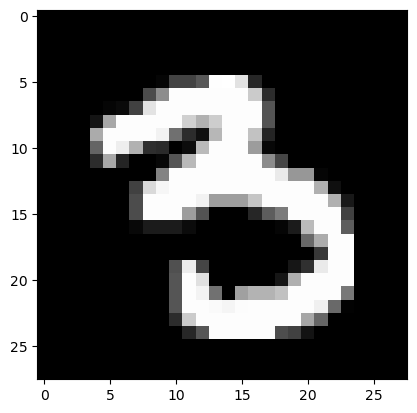

In [15]:
plot_tensor(train_data[0][0])

In [16]:
train_loader = th.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

In [17]:
len(train_loader)

525

In [18]:
model = ResNet().to(device=device, dtype=dtype)
loss = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

In [19]:
from tqdm.notebook import trange

In [20]:
for ep in trange(epochs):
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss_val = loss(output, target)
        loss_val.backward()
        optimizer.step()
    print(f"Epoch {ep}, Loss {loss_val.item()}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0, Loss 0.36116963624954224
Epoch 1, Loss 0.12273142486810684
Epoch 2, Loss 0.05625316873192787
Epoch 3, Loss 0.056310635060071945
Epoch 4, Loss 0.1611524224281311
Epoch 5, Loss 0.02707190439105034
Epoch 6, Loss 0.06920625269412994
Epoch 7, Loss 0.035314276814460754
Epoch 8, Loss 0.01051785983145237
Epoch 9, Loss 0.03362848609685898


In [21]:
from tqdm.notebook import tqdm

In [22]:
correct = 0
total = 0
for data, target in tqdm(test_data):
    output = model(data.unsqueeze(0))
    _, predicted = th.max(output, 1)
    total += 1
    correct += (predicted == target).item()

  0%|          | 0/8400 [00:00<?, ?it/s]

In [23]:
correct / total

0.8076190476190476

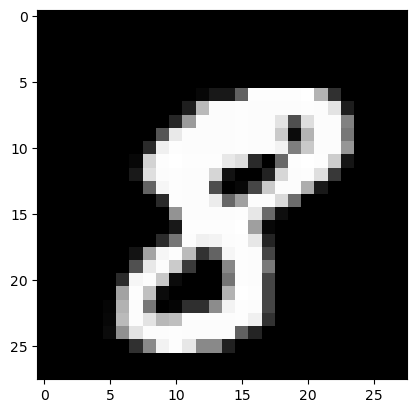

In [24]:
plot_tensor(test_data[0][0])

In [25]:
output = model(test_data[0][0].unsqueeze(0))
_, predicted = th.max(output, 1)

In [26]:
predicted

tensor([8], device='mps:0')

In [27]:
th.save(model.state_dict(), "resnet.pth")